In [1]:
import os

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import LinearLocator
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

print("Package is ready.")

Package is ready.


In [2]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

# 2020 Summer

## Control weight

In [3]:
SW2_df = pd.read_csv('./results/2020_S/SW2_greenhouse.csv', index_col='Unnamed: 0')
SW2_df.index = pd.DatetimeIndex(SW2_df.index)

### Cultivation period

In [4]:
SW2_df = SW2_df.loc['2020-03-05 00:00:00': '2020-07-03 23:59:00']
SW2_df = SW2_df.interpolate()

### Rockwool weight

In [5]:
rockwool_mean = 656.50/1000

### water weight

In [6]:
substrate_volume = (120*12*7.5 + 10*10*6.5*4)/1000
water_w_df = substrate_volume*SW2_df['subs_VWC']/100
SW2_df['water'] = water_w_df

### Calculating aerial weight

In [7]:
SW2_df.loc[:, 'loadcell_1'] = SW2_df.loc[:, 'loadcell_1'] - rockwool_mean
SW2_df.loc[:, 'loadcell_2'] = SW2_df.loc[:, 'loadcell_2'] - rockwool_mean
SW2_df.loc[:, 'loadcell_3'] = SW2_df.loc[:, 'loadcell_3'] - rockwool_mean

### Destructive crop weight

In [8]:
weight_df = pd.read_csv('./results/2020_S/weight_ct.csv', index_col='Unnamed: 0')
weight_df.index = pd.DatetimeIndex(weight_df.index)
weight_df.index = np.append(weight_df.index[:-20], pd.DatetimeIndex(['2020-07-03']*20))
wweight_df = weight_df[['Stem FW', 'Leaf FW', 'petiole FW', 'Idv fruit FW']].sum(axis=1)

### Root DW to FW

In [9]:
roots_DW_mean = 297.27
DW_sum_df = weight_df.loc[:, [_ for _ in weight_df.columns if _.endswith('DW')]].sum(axis=1)
rs_ratio_df = (roots_DW_mean/(DW_sum_df.loc['2020-07-03']*4)).mean()

In [10]:
roots_df = pd.DataFrame(DW_sum_df * rs_ratio_df)
roots_df.columns = ['root DW']
roots_df['root FW'] = roots_df['root DW']/0.1325
roots_df.index = pd.DatetimeIndex(roots_df.index)
wweight_wr_df = wweight_df.add(roots_df['root FW'])

### Excepting irrigation disturbance

In [11]:
night_df = SW2_df.loc[SW2_df['rad'] <= 0.2, 'loadcell_1':'loadcell_3']

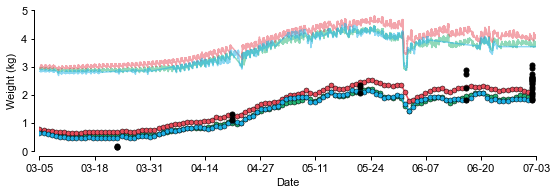

In [12]:
fig = plt.figure(figsize=((8/2.54*2.5), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_1']/4, c=cmap[3], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_2']/4, c=cmap[0], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_3']/4, c=cmap[4], alpha=0.5)

ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/4), '-o', ms=5, mec='k', mew=0.5, c=cmap[3])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/4), '-o', ms=5, mec='k', mew=0.5, c=cmap[0])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/4), '-o', ms=5, mec='k', mew=0.5, c=cmap[4])

ax0.plot(wweight_df.index, wweight_wr_df/1000, 'o', ms=5, c='k')

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(6))
ax0.set_ybound(0, 5)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

fig.tight_layout()
plt.show()

In [13]:
fw_labels = pd.concat([(night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/4,
                       (night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/4,
                       (night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/4], axis=1)
fw_labels.columns = ['CT_1', 'CT_2', 'CT_3']

In [14]:
fw_labels.to_csv('./results/2020_S/ct_fw_labels.csv')

# 2020 Winter

## Control weight

In [15]:
SW2_df = pd.read_csv('./results/2020_W/SW_CT_greenhouse.csv', index_col='Unnamed: 0')
SW2_df.index = pd.DatetimeIndex(SW2_df.index)

### Cultivation period

In [16]:
SW2_df = SW2_df.loc['2020-08-26 00:00:00': '2021-01-25 23:59:00']
SW2_df = SW2_df.interpolate()

### Rockwool weight

In [17]:
rockwool_mean = 887.20/1000

### water weight

In [18]:
substrate_volume = (120*12*7.5 + 10*10*6.5*3)/1000
water_w_df = substrate_volume*SW2_df['subs_VWC']/100
SW2_df['water'] = water_w_df

### Calculating aerial weight

In [19]:
SW2_df.loc[:, 'loadcell_1'] = SW2_df.loc[:, 'loadcell_1'] - rockwool_mean
SW2_df.loc[:, 'loadcell_2'] = SW2_df.loc[:, 'loadcell_2'] - rockwool_mean
SW2_df.loc[:, 'loadcell_3'] = SW2_df.loc[:, 'loadcell_3'] - rockwool_mean

### Destructive crop weight

In [20]:
weight_df = pd.read_csv('./results/2020_W/weight_ct.csv', index_col='Unnamed: 0')
weight_df.index = pd.DatetimeIndex(weight_df.index)
wweight_df = weight_df[['Stem FW', 'Leaf FW', 'petiole FW', 'Idv fruit FW']].sum(axis=1)

### Root DW to FW

In [21]:
roots_DW_mean = 355.37
DW_sum_df = weight_df.loc[:, [_ for _ in weight_df.columns if _.endswith('DW')]].sum(axis=1)
rs_ratio_df = (roots_DW_mean/(DW_sum_df.loc['2021-01-25']*3)).mean()

In [22]:
roots_df = pd.DataFrame(DW_sum_df * rs_ratio_df)
roots_df.columns = ['root DW']
roots_df['root FW'] = roots_df['root DW']/0.1325
roots_df.index = pd.DatetimeIndex(roots_df.index)
wweight_wr_df = wweight_df.add(roots_df['root FW'])

### Excepting irrigation disturbance

In [23]:
night_df = SW2_df.loc[SW2_df['rad'] <= 0.2, 'loadcell_1':'loadcell_3']

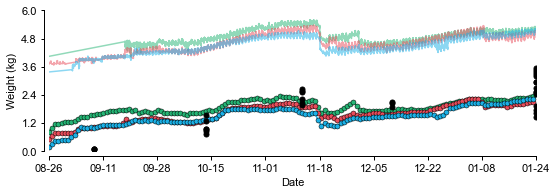

In [24]:
fig = plt.figure(figsize=((8/2.54*2.5), (6/2.54*1.2)))
ax0 = plt.subplot()

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 5))
ax0.spines['bottom'].set_position(('outward', 5))

ax0.plot(SW2_df.index, SW2_df['loadcell_1']/3, c=cmap[3], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_2']/3, c=cmap[0], alpha=0.5)
ax0.plot(SW2_df.index, SW2_df['loadcell_3']/3, c=cmap[4], alpha=0.5)

ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/3), '-o', ms=5, mec='k', mew=0.5, c=cmap[3])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/3), '-o', ms=5, mec='k', mew=0.5, c=cmap[0])
ax0.plot(night_df.resample('1d').mean().index, ((night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/3), '-o', ms=5, mec='k', mew=0.5, c=cmap[4])

ax0.plot(wweight_df.index, wweight_wr_df/1000, 'o', ms=5, c='k')

ax0.set_xbound(SW2_df.index.min(), SW2_df.index.max())
ax0.xaxis.set_major_locator(LinearLocator(10))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(LinearLocator(6))
ax0.set_ybound(0, 6)

ax0.set_xlabel('Date')
ax0.set_ylabel('Weight (kg)')

fig.tight_layout()
plt.show()

In [25]:
fw_labels = pd.concat([(night_df.resample('1d').mean()['loadcell_1'] - SW2_df['water'].resample('1d').mean())/3,
                       (night_df.resample('1d').mean()['loadcell_2'] - SW2_df['water'].resample('1d').mean())/3,
                       (night_df.resample('1d').mean()['loadcell_3'] - SW2_df['water'].resample('1d').mean())/3], axis=1)
fw_labels.columns = ['CT_1', 'CT_2', 'CT_3']

In [26]:
fw_labels.to_csv('./results/2020_W/ct_fw_labels.csv')